In [1]:
import pandas as pd
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

In [2]:

def version_to_run_config(unix_seconds):
    # "/mnt/ssd-2/spar/alexm/dlk-benchmarking/wandb/run-20230718_002056-tka2fnu1/files/config.yaml"
    for child in os.listdir("/mnt/ssd-2/spar/alexm/dlk-benchmarking/wandb/"):
        if not os.path.isdir(f"/mnt/ssd-2/spar/alexm/dlk-benchmarking/wandb/{child}"):
            continue
        # check if unix_seconds is a substring of "save_name" of the in the config.yaml file
        # (if it exists)
        config_path = f"/mnt/ssd-2/spar/alexm/dlk-benchmarking/wandb/{child}/files/config.yaml"
        with open(config_path, "r") as f:
            config = yaml.safe_load(f)
        if "save_name" in config:
            if str(unix_seconds) in config["save_name"]["value"]:
                return child, config
    return None, None

def get_cfg_str(config, keys=["lora_rank", "objective", "lie_mode", "n_epochs"]):
    if config is None:
        return None
    vals = []
    for key in keys:
        vals.append(f"{key}=" + str(config[key]["value"]))
    return "; ".join(vals)

def get_url(child):
    if child is None: return None
    return f"https://wandb.ai/latent-knowledge/weak-deception/runs/{child.split('-')[-1]}"


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
p_by_version = {1692681636: 0.9, 1692472192: 1, 1692681561: 0.9, 1692471371: 1}

version = 1692471371 # 1692471371 # 1692472192 # versions[-1]
modifier = str(p_by_version[version])
from_ds_name = f"atmallen/sloppy_addition_alice_{modifier}"
to_ds_name = f"atmallen/sloppy_addition_bob_{modifier}"
ds_names = [to_ds_name, from_ds_name]
transfer_name = "+".join(ds_names)
transfer_from_base = False
inlp_iter = 0  # 4 has high transfer auroc to bob in last layers for 1692126045

from_reporter_dir = f"../../elk/elk-reporters/base-to-deceptive-lora/v{version}/{from_ds_name}" if transfer_from_base else f"../../elk/elk-reporters/deceptive-lora/v{version}/{from_ds_name}"
transfer_reporter_dir = f"../../elk/elk-reporters/base-to-deceptive-lora/v{version}/{from_ds_name}/transfer/{transfer_name}" if transfer_from_base else f"../../elk/elk-reporters/deceptive-lora/v{version}/{from_ds_name}/transfer/{transfer_name}"

In [16]:
transfer = True
annotator = "bob"
reporter_dir = from_reporter_dir if not transfer else transfer_reporter_dir

methods = {"LR": "lr_eval.csv", "reporter": "eval.csv", "LM": "lm_eval.csv"}
master_df = pd.DataFrame()
for method, eval_file in methods.items():
    df = pd.read_csv(os.path.join(reporter_dir, eval_file))
    if method == "LR":
        df = df[df["inlp_iter"] == inlp_iter]
        pass
    df = df[df["dataset"].str.contains(annotator)]
    df["method"] = method
    master_df = pd.concat([master_df, df])
master_df

child, config = version_to_run_config(version)
cfg_str = get_cfg_str(config)
wandb_url = get_url(child)
print(reporter_dir)
print(cfg_str)
print(wandb_url)

../../elk/elk-reporters/deceptive-lora/v1692471371/atmallen/sloppy_addition_alice_1/transfer/atmallen/sloppy_addition_bob_1+atmallen/sloppy_addition_alice_1
lora_rank=2; objective=standard; lie_mode=honest; n_epochs=10
https://wandb.ai/latent-knowledge/weak-deception/runs/run


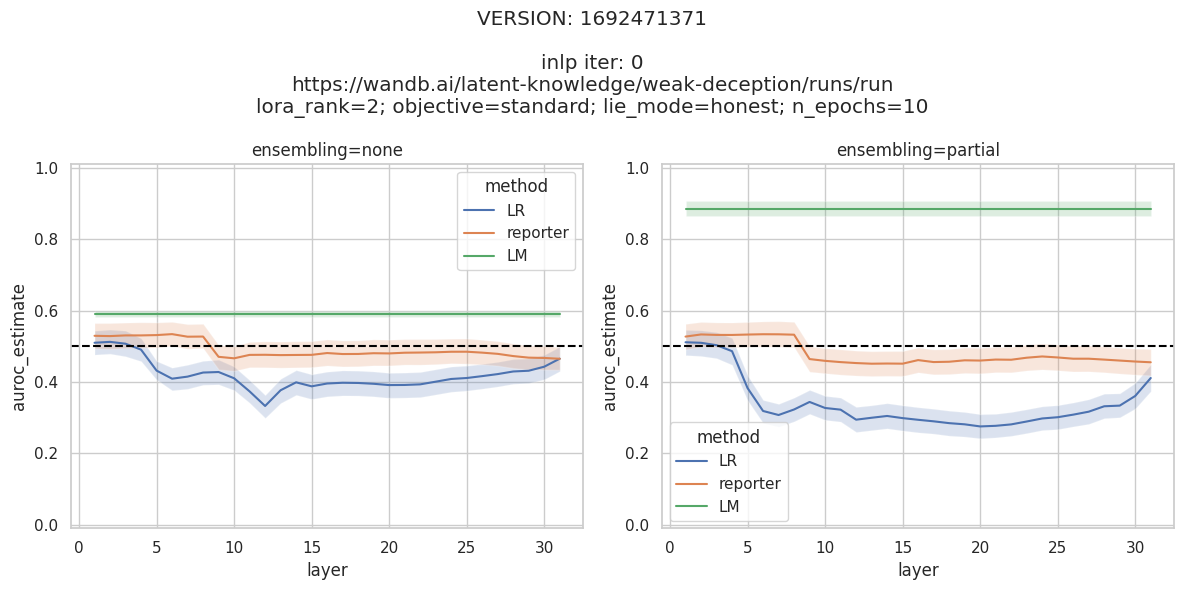

https://wandb.ai/latent-knowledge/weak-deception/runs/run
atmallen/sloppy_addition_bob_1


In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
metric = "auroc"
ens = "none"
df = master_df[master_df["ensembling"] == ens]
sns.lineplot(data=df, x="layer", y=f"{metric}_estimate", hue="method", errorbar=None)
for method in methods:
    sub_df = df[df["method"] == method]
    plt.fill_between(sub_df["layer"], sub_df[f"{metric}_lower"], sub_df[f"{metric}_upper"], alpha=0.2)
plt.title(f"ensembling={ens}")
plt.axhline(y=0.5, color="black", linestyle="--")
plt.ylim([-0.01, 1.01])
plt.subplot(1, 2, 2)
ens = "partial"
df = master_df[master_df["ensembling"] == ens]
sns.lineplot(data=df, x="layer", y=f"{metric}_estimate", hue="method", errorbar=None)
for method in methods:
    sub_df = df[df["method"] == method]
    plt.fill_between(sub_df["layer"], sub_df[f"{metric}_lower"], sub_df[f"{metric}_upper"], alpha=0.2)
plt.title(f"ensembling={ens}")
plt.axhline(y=0.5, color="black", linestyle="--")
plt.ylim([-0.01, 1.01])

maybe_trans = 'transfer from reporter trained on base model\n' if transfer_from_base else ''
plt.suptitle(f"VERSION: {version}\n{maybe_trans}\ninlp iter: {inlp_iter}\n{wandb_url}\n{cfg_str}")
plt.tight_layout()
plt.show()
print(wandb_url)
print(to_ds_name)


# Using probs.pt for fine-grained analysis

In [18]:
from_logprobs_dict = torch.load(os.path.join(from_reporter_dir, "logprobs.pt"))[from_ds_name]
to_logprobs_dict = torch.load(os.path.join(transfer_reporter_dir, "logprobs.pt"))[to_ds_name]
from_reporter_dir

'../../elk/elk-reporters/deceptive-lora/v1692471371/atmallen/sloppy_addition_alice_1'

In [19]:
import numpy as np
def get_logprobs_df(logprobs_dict, layer=24, inlp_iter=0, ens="partial"):
    if ens == "none":
        texts = np.array(logprobs_dict["texts"]).reshape(-1)
        labels = np.array(logprobs_dict["labels"]).repeat(2)  # this makes a copy of each element next to itself
        labels[::2] = 1 - labels[::2]  # the negative (first) element of the contrast pair has opposite label
        lm_probs = np.array(logprobs_dict["lm"][ens]).reshape(-1)  # same as flatten, sorted by dictionary order where first dimension is most important
        reporter_probs = np.array(logprobs_dict["reporter"][layer][ens]).reshape(-1)
        lr_probs = np.array(logprobs_dict["lr"][layer][ens][inlp_iter]).reshape(-1)
        
    elif ens == "partial":
        texts = np.array(logprobs_dict["texts"])[:, :, 0].squeeze()  # first and second element of contrast pair are same
        labels = np.array(logprobs_dict["labels"])
        lm_probs = np.array(logprobs_dict["lm"][ens]).squeeze(1)
        reporter_probs = np.array(logprobs_dict["reporter"][layer][ens]).squeeze(1)
        lr_probs = np.array(logprobs_dict["lr"][layer][ens][inlp_iter]).squeeze(1)

    df = pd.DataFrame({"text": texts, "label": labels, "lm": lm_probs, "reporter": reporter_probs, "lr": lr_probs})
    return df

In [36]:
import random
from sklearn.metrics import roc_auc_score

layers = range(1, 32)
ens_list = ["none", "partial"]
inlp_iter = 0
results = []
for ens in ens_list:
    for layer in layers:
        logprobs_df = get_logprobs_df(to_logprobs_dict, layer=layer, ens=ens, inlp_iter=inlp_iter)

        # get both Alice's and Bob's labels
        # TODO: This is really bad code, I should make sure the labels actually match
        alice_labels = []
        bob_labels = []
        for i, text in enumerate(logprobs_df["text"]):
            text = text.removesuffix(". Bob:").removesuffix(". Alice:")
            lhs, rhs = text.split(" = ")
            summand1, summand2 = lhs.split(" + ")
            alice_label = int(summand1) + int(summand2) == int(rhs)
            
            sloppy_sum = "".join([(str(int(c) + 1) if i == 0 and random.random() < float(modifier) else c) for i, c in enumerate(str(int(summand1) + int(summand2)))])
            bob_label = sloppy_sum == str(rhs)

            is_neg = i % 2 == 0 and ens == "none"  # is it the positive or the negative example in the contrast pair
            if is_neg:
                alice_label = not alice_label
                bob_label = not bob_label
            alice_labels.append(alice_label)
            bob_labels.append(bob_label)

        logprobs_df["alice_label"] = alice_labels
        logprobs_df["bob_label"] = bob_labels

        result = {"layer": layer, "ens": ens}
        for person in ["alice", "bob"]:
            result[f"lr_auroc_{person}"] = roc_auc_score(logprobs_df[f"{person}_label"], logprobs_df["lr"])
            result[f"lm_auroc_{person}"] = roc_auc_score(logprobs_df[f"{person}_label"], logprobs_df["lm"])
            result[f"reporter_auroc_{person}"] = roc_auc_score(logprobs_df[f"{person}_label"], logprobs_df["reporter"])

        results.append(result)

to_df = pd.DataFrame(results)

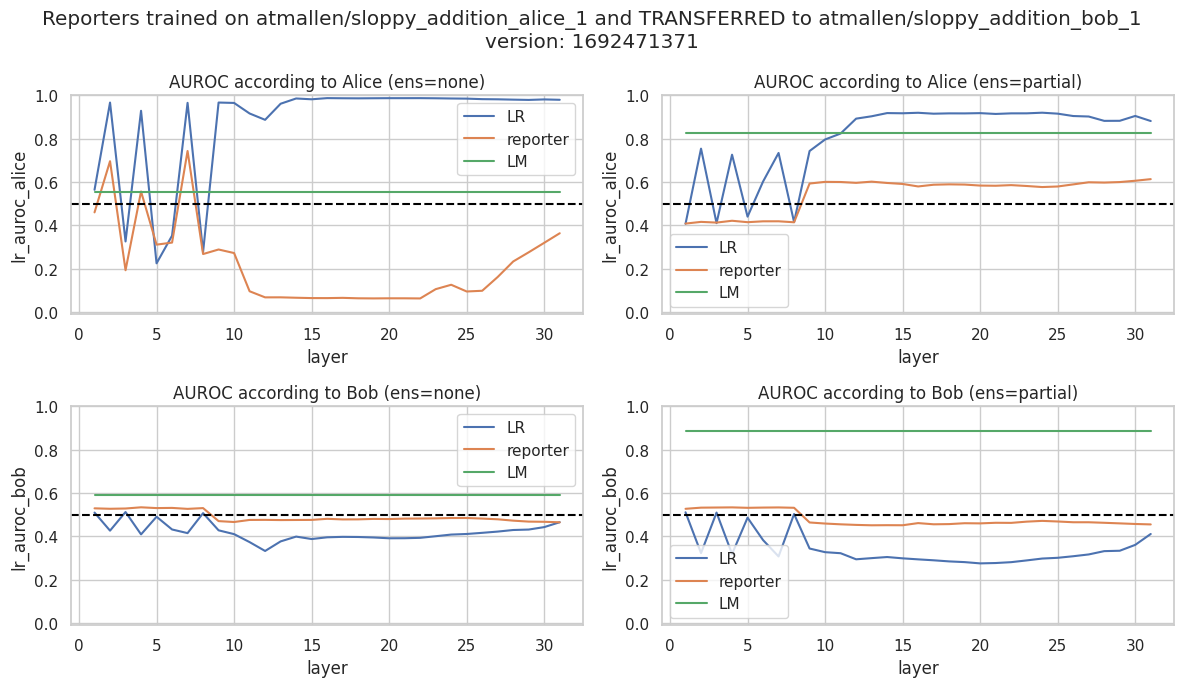

In [35]:
plt.figure(figsize=(12, 7))
plt.suptitle(f"Reporters trained on {from_ds_name} and TRANSFERRED to {to_ds_name}\nversion: {version}")
for i, ens in enumerate(ens_list):
    for j, person in enumerate(["alice", "bob"]):
        plt.subplot(2, 2, 2*j + i + 1)
        plot_df = to_df[to_df["ens"] == ens]
        sns.lineplot(plot_df, x="layer", y=f"lr_auroc_{person}", label="LR")
        sns.lineplot(plot_df, x="layer", y=f"reporter_auroc_{person}", label="reporter")
        sns.lineplot(plot_df, x="layer", y=f"lm_auroc_{person}", label="LM")
        plt.axhline(y=0.5, color="black", linestyle="--")
        plt.title(f"AUROC according to {person.capitalize()} (ens={ens})")
        plt.ylim(-0.01, 1)

plt.tight_layout()
plt.show()

In [23]:
a = logprobs_df["alice_label"]
b = logprobs_df["bob_label"]

both = sum(a & b)
neither = sum(~a & ~b)
alice_only = sum(a & ~b)
bob_only = sum(~a & b)
print("Both:", both)
print("Neither:", neither)
print("Alice only:", alice_only)
print("Bob only:", bob_only)

Both: 0
Neither: 446
Alice only: 54
Bob only: 500


## On-distribution reporter performance

In [10]:
import random
from sklearn.metrics import roc_auc_score

layers = range(1, 32)
ens_list = ["none", "partial"]
inlp_iter = 0
results = []
for ens in ens_list:
    for layer in layers:
        logprobs_df = get_logprobs_df(from_logprobs_dict, layer=layer, ens=ens, inlp_iter=inlp_iter)

        # get both Alice's and Bob's labels
        # TODO: This is really bad code, I should make sure the labels actually match
        alice_labels = []
        bob_labels = []
        for i, text in enumerate(logprobs_df["text"]):
            text = text.removesuffix(". Bob:").removesuffix(". Alice:")
            lhs, rhs = text.split(" = ")
            summand1, summand2 = lhs.split(" + ")
            alice_label = int(summand1) + int(summand2) == int(rhs)
            
            sloppy_sum = "".join([(str(int(c) + 1) if i == 0 and random.random() < float(modifier) else c) for i, c in enumerate(str(int(summand1) + int(summand2)))])
            bob_label = sloppy_sum == str(rhs)

            is_neg = i % 2 == 0 and ens == "none"  # is it the positive or the negative example in the contrast pair
            if is_neg:
                alice_label = not alice_label
                bob_label = not bob_label
            alice_labels.append(alice_label)
            bob_labels.append(bob_label)

        logprobs_df["alice_label"] = alice_labels
        logprobs_df["bob_label"] = bob_labels

        result = {"layer": layer, "ens": ens}
        for person in ["alice", "bob"]:
            result[f"lr_auroc_{person}"] = roc_auc_score(logprobs_df[f"{person}_label"], logprobs_df["lr"])
            result[f"lm_auroc_{person}"] = roc_auc_score(logprobs_df[f"{person}_label"], logprobs_df["lm"])
            result[f"reporter_auroc_{person}"] = roc_auc_score(logprobs_df[f"{person}_label"], logprobs_df["reporter"])

        results.append(result)

from_df = pd.DataFrame(results)

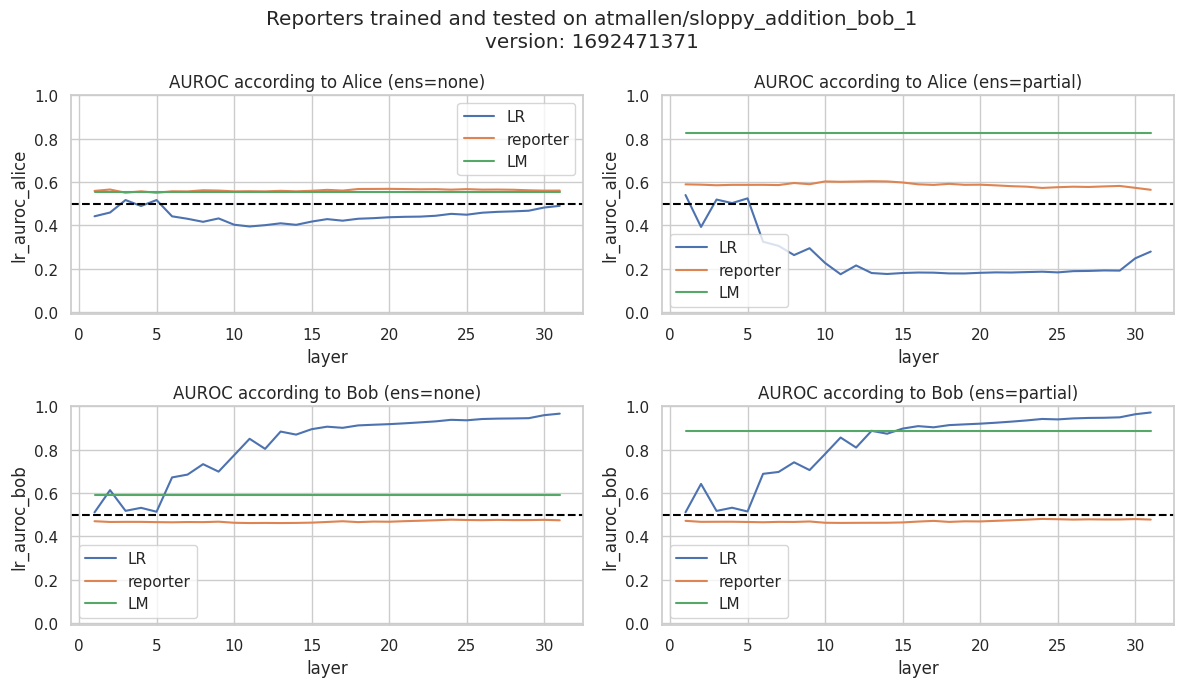

In [13]:
plt.figure(figsize=(12, 7))
plt.suptitle(f"Reporters trained and tested on {from_ds_name}\nversion: {version}")
for i, ens in enumerate(ens_list):
    for j, person in enumerate(["alice", "bob"]):
        plt.subplot(2, 2, 2*j + i + 1)
        plot_df = from_df[from_df["ens"] == ens]
        sns.lineplot(plot_df, x="layer", y=f"lr_auroc_{person}", label="LR")
        sns.lineplot(plot_df, x="layer", y=f"reporter_auroc_{person}", label="reporter")
        sns.lineplot(plot_df, x="layer", y=f"lm_auroc_{person}", label="LM")
        plt.axhline(y=0.5, color="black", linestyle="--")
        plt.title(f"AUROC according to {person.capitalize()} (ens={ens})")
        plt.ylim(-0.01, 1)

plt.tight_layout()
plt.show()